In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/torch3090/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


In [4]:
config["operator_params"]["operator"] = "CompressedSensing"
config["operator_params"]["num_measurements"] = 200

In [5]:
config["estimator_params"]["initalisation"] = "random"
config["exp_params"]["batch_size"] = 100
config["estimator_params"]["mode"] = "avg"
dm = mnist_dataloader_test(config, path=path)

In [6]:
posterior = []
error_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    posterior.append(e_x)
    error_posterior.append(std)

100%|██████████| 15/15 [01:20<00:00,  5.37s/it]


In [7]:
config["estimator_params"]["initalisation"] = "random"
config["exp_params"]["batch_size"] = 100
config["estimator_params"]["mode"] = "denoise_avg"
config["estimator_params"]["denoise_step_size"] = 0.1
dm = mnist_dataloader_test(config, path=path)

In [8]:
denoise_posterior = []
error_denoise_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    denoise_posterior.append(e_x)
    error_denoise_posterior.append(std)

100%|██████████| 15/15 [01:20<00:00,  5.38s/it]


In [9]:
config["estimator_params"]["mode"] = "last"

In [10]:
last_posterior = []
error_last_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    last_posterior.append(e_x)
    error_last_posterior.append(std)

100%|██████████| 15/15 [01:20<00:00,  5.40s/it]


In [11]:
config["estimator_params"]["mode"] = "denoise_last"
config["estimator_params"]["denoise_step_size"] = 0.1

In [12]:
denoise_last_posterior = []
error_denoise_last_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    denoise_last_posterior.append(e_x)
    error_denoise_last_posterior.append(std)

100%|██████████| 15/15 [01:24<00:00,  5.60s/it]


In [13]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

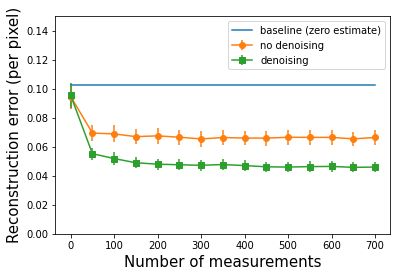

In [16]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), posterior, yerr=error_posterior, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), denoise_last_posterior, yerr=error_denoise_last_posterior , fmt='-s')
plt.legend(['baseline (zero estimate)','no denoising', 'denoising'])
plt.show()

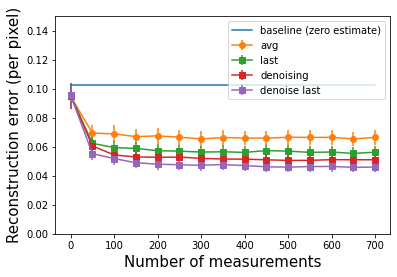

In [15]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), posterior, yerr=error_posterior, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), last_posterior, yerr=error_last_posterior , fmt='-s')
plt.errorbar(list(range(0, 750, 50)), denoise_posterior, yerr=error_denoise_posterior , fmt='-s')
plt.errorbar(list(range(0, 750, 50)), denoise_last_posterior, yerr=error_denoise_last_posterior , fmt='-s')
plt.legend(['baseline (zero estimate)','avg', 'last', 'denoising', 'denoise last'])
plt.show()